<div class="alert alert-block alert-success">
A green text box indicates a code cell that must be run, without alteration, to complete the workflow.
</div>

<div class="alert alert-block alert-warning">
An orange text box indicates an optional code cell that doesn't have to be run to complete the workflow, but can be run to complete optional tasks.
</div>

<div class="alert alert-block alert-info">
A blue text box indicates a code cell that requires user input - this cell also must be run to complete the workflow, but the user needs to modify the command in the cell.
</div>

<div class="alert alert-block alert-danger">
In addition, some text boxes contain particularly important information. These will be coloured red.
</div>

# <span style="color:green"> Import python functions </sapan>
<div class="alert alert-block alert-success">
    These packages should all be installed and available in your default environment. eResearch can help with installing modules and setting up environments. 
</div>


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import scipy
from scipy import stats as stats
from copy import copy as copy

from openpyxl import load_workbook
from openpyxl.worksheet.table import Table

# from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from sklearn.neighbors import kneighbors_graph


# <span style="color:green"> Define/Import custom functions </sapan>
<div class="alert alert-block alert-success">
    Custom functions for this workflow are imported from the functions folder. 
</div>

In [2]:
from functions.plotting import(
    volcanoPlot, 
    plot_dendrogram,
    get_factor_colours,
    get_connectivity
    )

In [3]:
from functions.eda import (get_AggloModel)

# <span style="color:orange"> Configure output options for this run </span>

<div class="alert alert-block alert-warning">
    The writeOutput variable below enables high level control for whether output files are written. This can be turned off to prevent overwriting existing files. <br>
    AutoRunProject allows the selection of a folder location from a projects.txt config file
</div>

In [4]:
writeOutput = False
# writeOutput = True


## <span style="color:blue"> Read in config file </sapan>
<div class="alert alert-block alert-info">
    If running in autoRunProject mode, a project.txt file is used to hold all current projects, with one project per line. Inactive projects or comment lines start with a #. The project to run must be uncommented.<br>
A config file (config.txt) or project file (project.txt) must be present in the folder given in the projects file or can be entered in the text below.
</div>

In [5]:
autoRunProject = True
# autoRunProject = False

if autoRunProject:
    with open('projects.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if ((not line.startswith('#')) and (not line.strip()=='')):
                subfolder = line
else:
    subfolder = input("Enter the name of the working folder (Must be same level as code folder)")

print(subfolder)

os.chdir("../" + subfolder)
# os.getcwd()

Batra_EOI


In [6]:
# Show current working directory to confirm that directory has been changed
os.getcwd()

'/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Batra_EOI'

In [7]:
# read in paths from config file
configDict = {
    'rootDir': '',
    'initialDataPath' : '',
    'QCDataPath' : '',
    'labWorksheet01Path':'',
    'sampleInfoFile' : '',
    'projectName':'',
    'selectedData': []
}

with open('./config.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith('#'):
            line = line.strip()
            fields = line.split(':')

            if fields[0].strip()=='initialDataPath':
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
            elif fields[0].strip()=='probeThresholdIdx':
                configDict[fields[0].strip()] = int(fields[1].strip().strip('\''))
            elif fields[0].strip()=='selectedData':
                tempList = fields[1].strip().strip('\'').split(',')
                tempList = [x.strip() for x in tempList]
                configDict['selectedData'] = tempList
            else:
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
## ToDo: Add checks to ensure that minimal fields have been populated. Raise errors or warnings

configDict

{'rootDir': '/Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/',
 'initialDataPath': 'Initial Dataset.xlsx',
 'QCDataPath': 'Default_QC.xlsx',
 'labWorksheet01Path': 'Lab_Worksheet_P1001660008734A.txt',
 'sampleInfoFile': 'sampleInfo_with_Wells.csv',
 'projectName': 'Batra_EOI',
 'selectedData': ['Col', 'Row'],
 'probeThresholdIdx': 32}

# <span style="color:green"> Run Analysis </sapan>
<div class="alert alert-block alert-success">
    description here
</div>

In [8]:
# ToDo:
# add sample info file details into config file in previous notebook
# sampleInfo_with_Wells.csv

In [9]:
# ToDo: Should initial filtering be done using none-mean-HKGeoMean normalised data. Using a type of background subtraction for filtering would bias towards removing noisy or low expressing samples. Removing these may give more accurate estimates of real probe values.

## <span style="color:green"> Read-in nanostring normalised data </sapan>
<div class="alert alert-block alert-success">
    Read in normalised data from the final step of the QC notebook. This includes many versions of normalised data for comparison to help choose the final normalisation approach.
</div>

In [10]:
normDir = os.path.join(configDict['rootDir'], 'Normalisation')
# print(normDir)
QCDataFile = [f for f in os.listdir(normDir) if (f.startswith('QC') and f.endswith('_preNorm.csv'))][0]
print(QCDataFile)


QC_Batra_EOI_preNorm.csv


In [11]:
os.listdir(normDir)

['NSNorm',
 'QC_Batra_EOI_preNorm.csv',
 'QC_Batra_EOI_RUV.csv',
 'QC_Batra_EOI_preNorm_Dropped.csv',
 'NSNormDropped']

### <span style="color:green"> Sort samples and probes  </sapan>
<div class="alert alert-block alert-success">
    Read and save the probe order and sample order from the pre normalisation data set for consistent organisation of data in plots.
</div>

In [12]:
QCDataDF = pd.read_csv(os.path.join(normDir, QCDataFile), index_col=0)
# QCDataDF.columns = [x.replace(' ','.') for x in QCDataDF.columns]
# QCDataDF.columns = [x.replace('-','.') for x in QCDataDF.columns]

codeClass = QCDataDF.loc[:,'Code.Class']

probeOrder = QCDataDF.index[8:]
sampleOrder = QCDataDF.columns[1:]

# sampleOrder

In [13]:
QCDataDF

,Code.Class,X24_008_3_4_5um_QUT_TMA3_001_Tumour,X24_008_3_4_5um_QUT_TMA3_002_TME,X24_008_3_4_5um_QUT_TMA3_002_Tumour,X24_008_3_4_5um_QUT_TMA3_003_TME,X24_008_3_4_5um_QUT_TMA3_003_Tumour,X24_008_3_4_5um_QUT_TMA3_004_Tumour,X24_008_3_4_5um_QUT_TMA3_005_TME,X24_008_3_4_5um_QUT_TMA3_005_Tumour,X24_008_3_4_5um_QUT_TMA3_006_TME,...,X24_008_3_4_5um_QUT_TMA1_025_TME,X24_008_3_4_5um_QUT_TMA1_025_Tumour,X24_008_3_4_5um_QUT_TMA1_028_TME,X24_008_3_4_5um_QUT_TMA1_028_Tumour,X24_008_3_4_5um_QUT_TMA1_029_Tumour,X24_008_3_4_5um_QUT_TMA1_031_Tumour,X24_008_3_4_5um_QUT_TMA1_032_Tumour,X24_008_3_4_5um_QUT_TMA1_034_Tumour,X24_008_3_4_5um_QUT_TMA1_038_TME,X24_008_3_4_5um_QUT_TMA1_038_Tumour
Name,,,,,,,,,,,,,,,,,,,,,
HYB-POS,Positive,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,...,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300
Ms IgG1,Negative,88.318370,15.564713,37.219936,52.260920,26.159107,34.030502,17.576359,33.942234,26.529974,...,11.509533,8.607013,19.780296,57.670895,13.070210,12.312470,19.126610,21.334110,8.508138,53.152554
Rb IgG,Negative,40.962685,11.180616,6.825781,21.395008,7.180270,15.048419,4.205146,12.785937,8.571124,...,5.224617,3.322979,9.102513,22.578619,4.004455,7.150788,6.909553,10.844656,5.607757,22.151590
Ms IgG2a,Negative,15.780657,7.439528,16.752287,6.716254,10.093098,5.619662,3.107048,5.834095,6.090702,...,7.490107,1.760256,6.893129,9.728003,7.256543,6.193330,8.219649,3.960484,2.751489,18.242323
HYB-NEG,Negative,1.991002,1.578515,1.988170,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.776323,1.000000,1.439413,1.000000,1.000000,1.723165,1.000000,5.697998,1.000000,1.150792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IDO1,Endogenous,2.067240,3.277912,1.988170,1.940209,1.000000,1.623422,1.000000,1.000000,1.000000,...,1.776323,1.587766,2.596309,1.551179,2.715535,1.789145,3.075947,2.366472,1.644071,1.150792
B7-H3,Endogenous,1.000000,1.578515,4.107736,2.926486,1.000000,1.000000,1.687476,2.762601,1.905870,...,1.776323,1.000000,2.413318,1.806325,1.779337,1.000000,2.015495,1.139600,1.000000,1.150792
VISTA,Endogenous,2.207986,1.578515,1.988170,2.072307,1.000000,3.638306,1.000000,1.000000,2.898633,...,1.776323,1.000000,1.334848,1.539196,1.910133,1.000000,2.163650,1.139600,1.000000,2.552415


In [14]:
# QCDataDF.columns = [x.replace(' ','.') for x in QCDataDF.columns]
# QCDataDF.columns = [x.replace('#','.') for x in QCDataDF.columns]
# QCDataDF.columns = [x.replace('/','.') for x in QCDataDF.columns]

## <span style="color:green"> Read-in sampleInfo </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [15]:
sampleInfo = pd.read_csv(os.path.join(configDict['rootDir'], configDict['sampleInfoFile']), index_col=0)

In [16]:
colTemp = sampleInfo.columns
# colTemp = [x.replace(' ','.') for x in colTemp]
# colTemp = [x.replace('-','.') for x in colTemp]
sampleInfo.columns = colTemp


sampleInfo = sampleInfo.loc[:,sampleOrder]

In [17]:
# sampleInfo.columns = [x.replace(' ','.') for x in sampleInfo.columns]
# sampleInfo.columns = [x.replace('#','.') for x in sampleInfo.columns]
# sampleInfo.columns = [x.replace('/','.') for x in sampleInfo.columns]

In [18]:
sampleInfo

,X24_008_3_4_5um_QUT_TMA3_001_Tumour,X24_008_3_4_5um_QUT_TMA3_002_TME,X24_008_3_4_5um_QUT_TMA3_002_Tumour,X24_008_3_4_5um_QUT_TMA3_003_TME,X24_008_3_4_5um_QUT_TMA3_003_Tumour,X24_008_3_4_5um_QUT_TMA3_004_Tumour,X24_008_3_4_5um_QUT_TMA3_005_TME,X24_008_3_4_5um_QUT_TMA3_005_Tumour,X24_008_3_4_5um_QUT_TMA3_006_TME,X24_008_3_4_5um_QUT_TMA3_006_Tumour,...,X24_008_3_4_5um_QUT_TMA1_025_TME,X24_008_3_4_5um_QUT_TMA1_025_Tumour,X24_008_3_4_5um_QUT_TMA1_028_TME,X24_008_3_4_5um_QUT_TMA1_028_Tumour,X24_008_3_4_5um_QUT_TMA1_029_Tumour,X24_008_3_4_5um_QUT_TMA1_031_Tumour,X24_008_3_4_5um_QUT_TMA1_032_Tumour,X24_008_3_4_5um_QUT_TMA1_034_Tumour,X24_008_3_4_5um_QUT_TMA1_038_TME,X24_008_3_4_5um_QUT_TMA1_038_Tumour
Custom Segment Name,24-008_3.4-5um QUT TMA3 | 001 | Tumour,24-008_3.4-5um QUT TMA3 | 002 | TME,24-008_3.4-5um QUT TMA3 | 002 | Tumour,24-008_3.4-5um QUT TMA3 | 003 | TME,24-008_3.4-5um QUT TMA3 | 003 | Tumour,24-008_3.4-5um QUT TMA3 | 004 | Tumour,24-008_3.4-5um QUT TMA3 | 005 | TME,24-008_3.4-5um QUT TMA3 | 005 | Tumour,24-008_3.4-5um QUT TMA3 | 006 | TME,24-008_3.4-5um QUT TMA3 | 006 | Tumour,...,24-008_3.4-5um QUT TMA1 | 025 | TME,24-008_3.4-5um QUT TMA1 | 025 | Tumour,24-008_3.4-5um QUT TMA1 | 028 | TME,24-008_3.4-5um QUT TMA1 | 028 | Tumour,24-008_3.4-5um QUT TMA1 | 029 | Tumour,24-008_3.4-5um QUT TMA1 | 031 | Tumour,24-008_3.4-5um QUT TMA1 | 032 | Tumour,24-008_3.4-5um QUT TMA1 | 034 | Tumour,24-008_3.4-5um QUT TMA1 | 038 | TME,24-008_3.4-5um QUT TMA1 | 038 | Tumour
ROI,942d3a98-5281-43e9-b498-5f5686e04725,9ea1616b-55bc-40a4-a731-329869706412,9ea1616b-55bc-40a4-a731-329869706412,be60c8fc-75b3-4cfd-9cef-55795383577f,be60c8fc-75b3-4cfd-9cef-55795383577f,4bb5810a-0586-4fc3-8a9f-aa443078a79f,354ff669-8a90-4ec1-942f-f5799a418f06,354ff669-8a90-4ec1-942f-f5799a418f06,8bef2498-b4fe-4a58-a313-c5e3c7c0599c,8bef2498-b4fe-4a58-a313-c5e3c7c0599c,...,b0da1ad5-1088-491c-967e-2bd53a4459f2,b0da1ad5-1088-491c-967e-2bd53a4459f2,8297df2c-de09-4a24-8ac9-c51ce418fc95,8297df2c-de09-4a24-8ac9-c51ce418fc95,bbfd8b4a-248b-46bc-b675-0d3d08f897af,47c08d2e-819c-4df1-8064-d265fc2369b6,57c0b037-61ca-490a-8f8a-e6d238e13500,c50c4f1b-96f2-4c24-a4dc-d0a5933025e6,3c646570-fbc7-46fa-87ab-d782398f139e,3c646570-fbc7-46fa-87ab-d782398f139e
ROI (Label),001,002,002,003,003,004,005,005,006,006,...,025,025,028,028,029,031,032,034,038,038
Segment,bc001f47-ceda-495a-b0cc-2a9b2a33e3be,8a1b59cc-5c93-4721-b89e-0bdfcee8dbc8,24802834-976a-4d8c-9033-166c210d28f9,cf37ae9c-5efe-466a-9637-8b1a110a7175,eba61c50-0693-45cc-ac67-9a4064575dfc,7f5755e9-df0c-42a3-a74f-944ee1137108,5246c7ed-6d30-4bc2-b439-17f8b06386a7,c21b8893-ab79-48fb-ac96-85bfd76f3ef9,841dafaa-4571-4a94-af65-0af1aad1203f,f6e08993-e582-4e65-a787-67d00a6b2a64,...,c863a473-3e92-408c-9abf-3a304d33b03f,fb927013-845f-46ba-b50b-87cd4a7c0591,ae43ebd7-8223-4e4a-bd79-505340b7c015,8bef83a3-2226-43cb-ace8-12609ada578b,bc92b60d-d974-4b39-9880-86076184f2be,c0181077-9e96-4b32-b2b9-8338d2edde66,e29876d7-ff8e-4853-9029-e1d97e0e962a,e2cc3121-ab1c-4793-ba09-446edb07487b,a64b179b-a4db-4191-a928-1db88b64f9fe,c36e0898-2166-4439-b029-a65c7c68aa64
Segment (Name/ Label),Tumour,TME,Tumour,TME,Tumour,Tumour,TME,Tumour,TME,Tumour,...,TME,Tumour,TME,Tumour,Tumour,Tumour,Tumour,Tumour,TME,Tumour
ROI X Coordinate,40834.2109375,32751.734375,32751.734375,19824.18359375,19824.18359375,39283.0703125,40304.69140625,40304.69140625,21118.0,21118.0,...,17018.908203125,17018.908203125,14108.4072265625,14108.4072265625,14379.333984375,14682.5322265625,14740.255859375,12966.67578125,9870.5576171875,9870.5576171875
ROI Y Coordinate,46416.08984375,16553.056640625,16553.056640625,61512.95703125,61512.95703125,44309.1875,38752.71484375,38752.71484375,84265.0,84265.0,...,61063.796875,61063.796875,41510.3046875,41510.3046875,46191.90625,29534.91015625,30241.396484375,30690.734375,86695.484375,86695.484375
Segment Tags,Tumour,TME,Tumour,TME,Tumour,Tumour,TME,Tumour,TME,Tumour,...,TME,Tumour,TME,Tumour,Tumour,Tumour,Tumour,Tumour,TME,Tumour
AOI,1,1,1,1,1,1,1,1,1,1,...,1,1,

## <span style="color:green"> Read-in factros for use in data grouping from config file. </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [19]:
# factors = input('enter factors to be used for groups to check probe expression. separate multiple factors by a comma')
factors = configDict['selectedData']


In [20]:
# generate a dictionary to hold factors for group analysis
factorDict = {}
factorDict2 = {}

for f in factors:
    entries = list(set(sampleInfo.loc[f].values))
    print(f)
    print(entries)
    # print(sorted(entries))
    print()
    factorDict[f] = entries
    factorDict2[f] = {}
    for e in entries:
        factorDict2[f][e] = sampleInfo.columns[sampleInfo.loc[f] == e]
    

Col
['11', '07', '01', '03', '05', '12', '04', '09', '02', '08', '06', '10']

Row
['D', 'H', 'A', 'F', 'E', 'C', 'B', 'G']



In [21]:
# factorDict.keys()

In [22]:
# factorDict2

# <span style="color:green"> Visualise Nanostring Norm results and choose samples to be kept for final normalisation </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [23]:
# configDict

In [24]:
# QCDataDF

In [25]:
files = os.listdir(os.path.join(normDir, 'NSNorm'))
files = sorted(files)
print(f'number of files found :\t{len(files)}')

number of files found :	84


In [26]:
# probeOrder

In [27]:
# sampleOrder = [x.replace(' ','.') for x in sampleOrder]
# sampleOrder = [x.replace('#','.') for x in sampleOrder]
# sampleOrder = [x.replace('/','.') for x in sampleOrder]

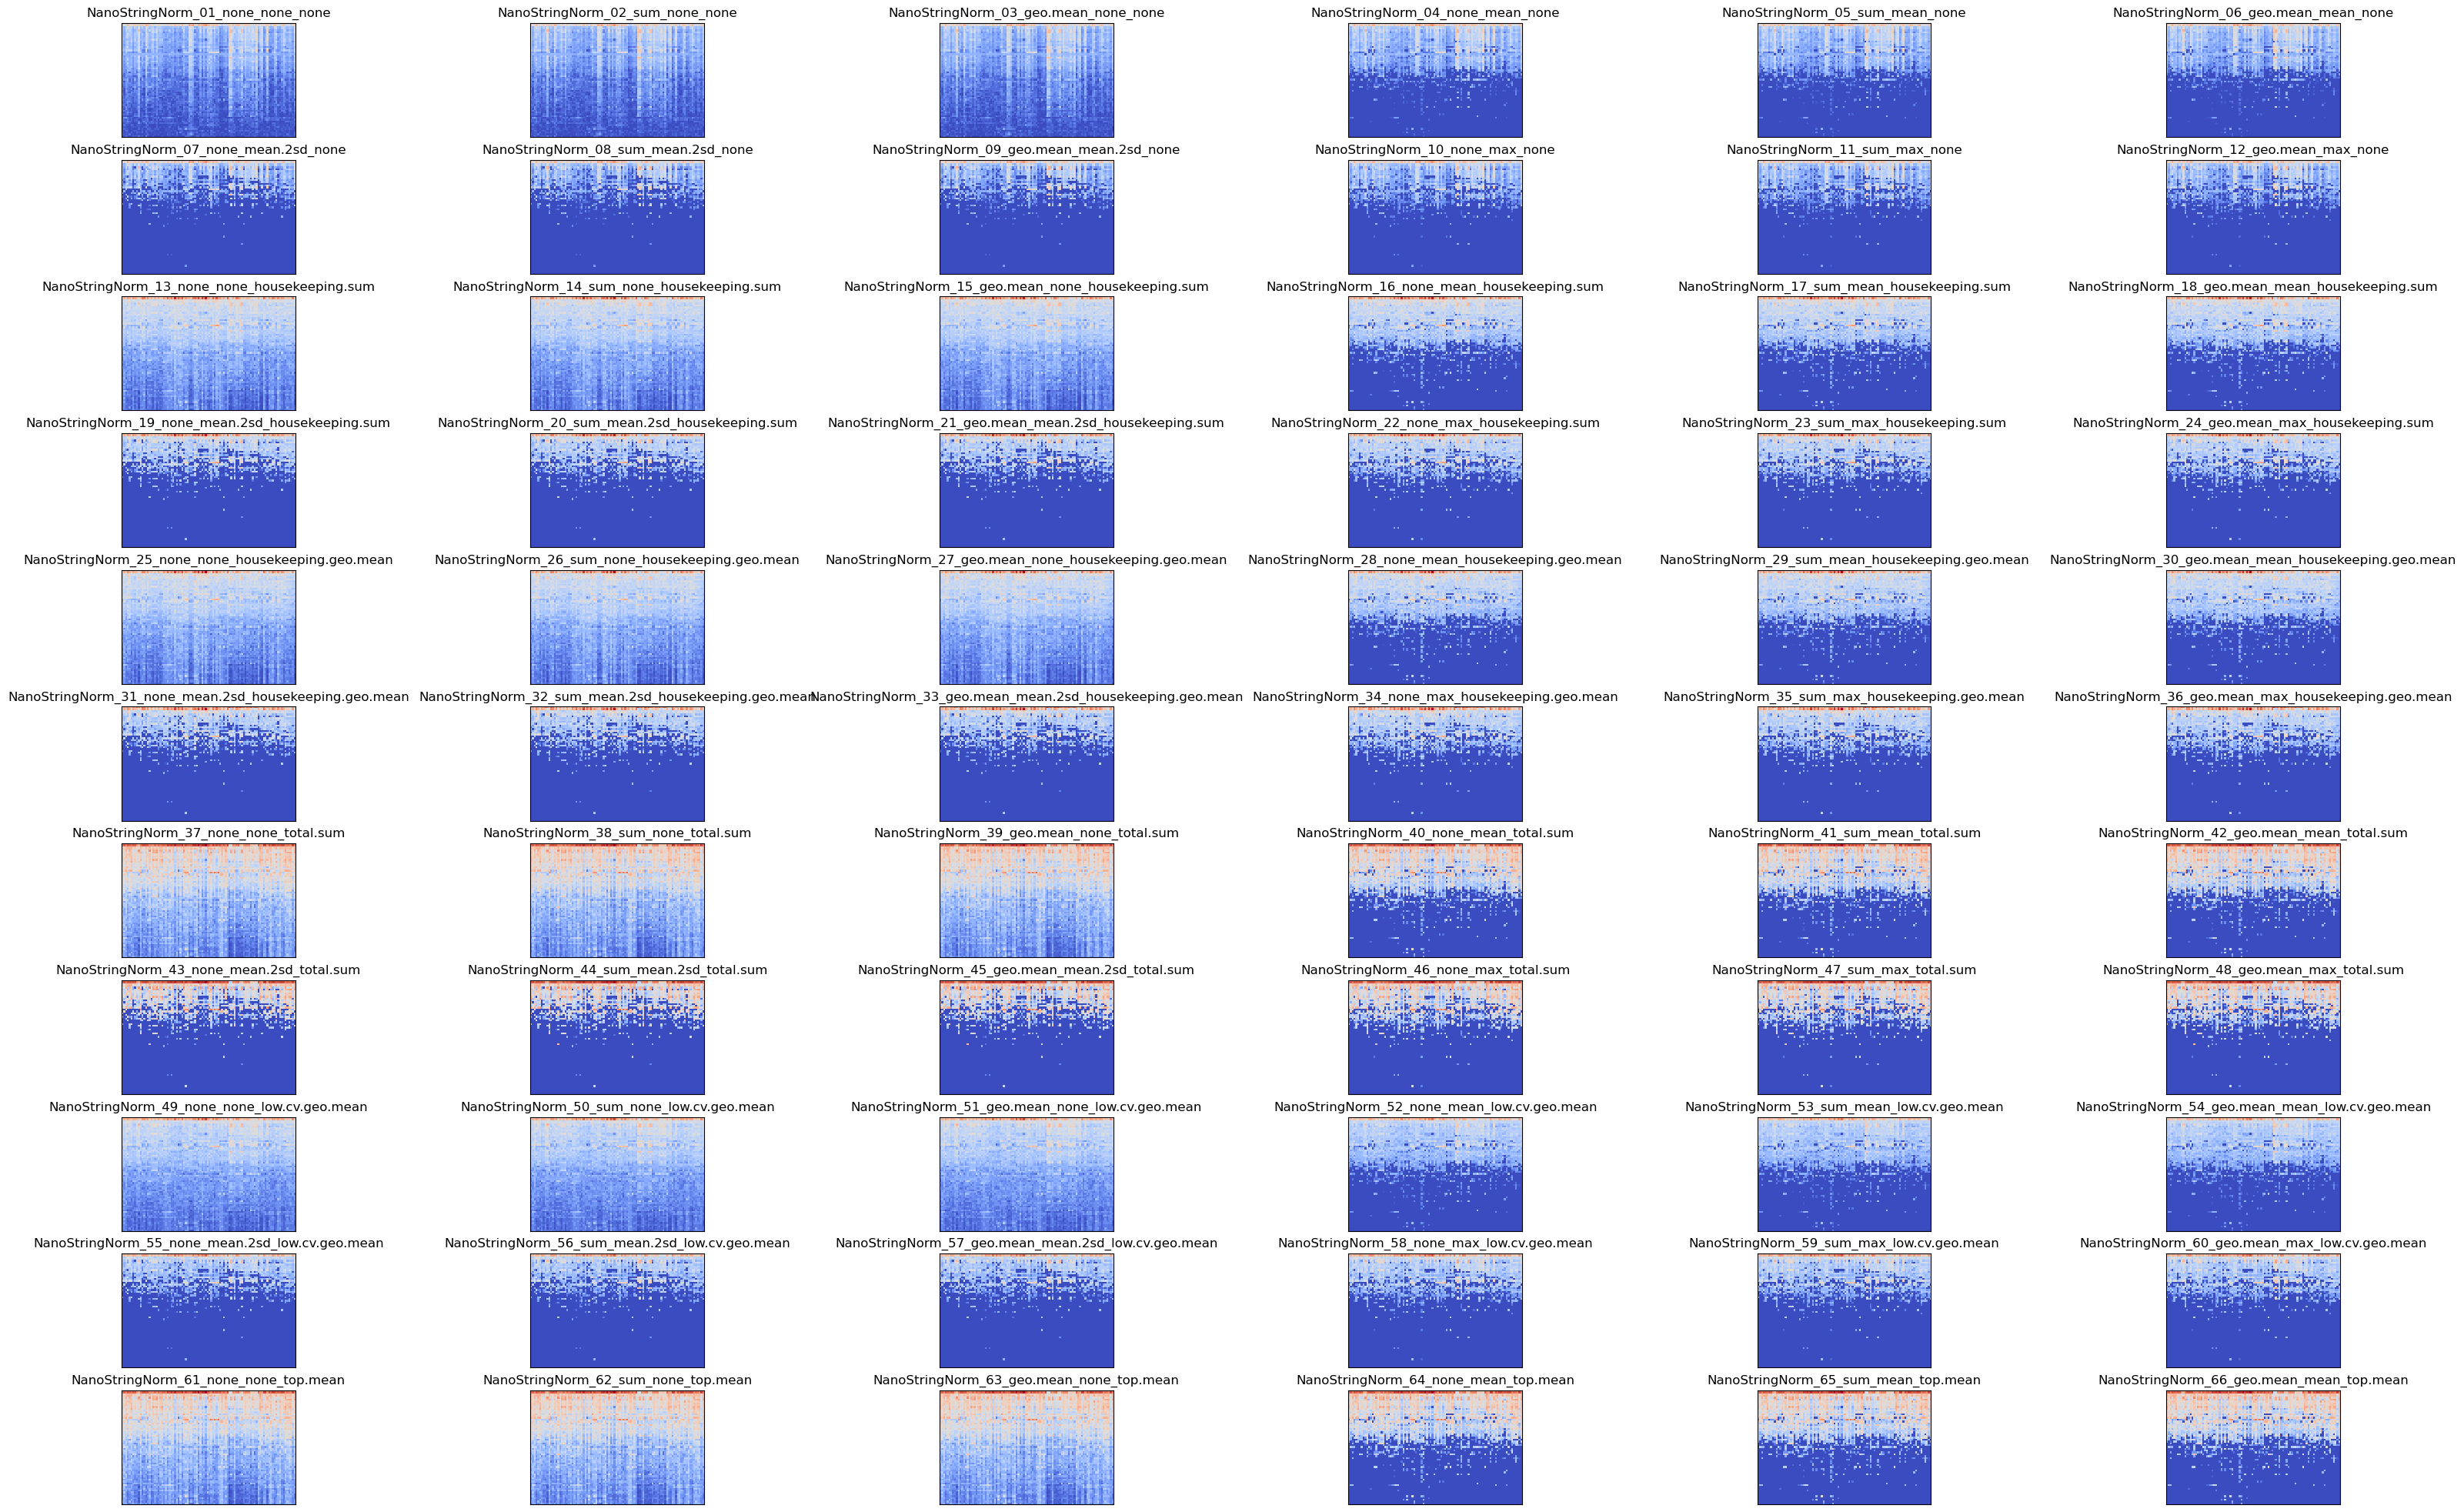

In [28]:
width = 6
height = 14
height = 11

fig, axs = plt.subplots(height, width, figsize=[40,25])
# fig.suptitle('Nanostring Normalisation heatmaps')

for y in range(height):
    for x in range(width):
        fileIdx = x + y*width
        tempDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[fileIdx]), index_col=0)
#         axs[y][x].matshow(np.log2(tempDF + 1), aspect = 'auto', cmap='coolwarm')
        axs[y][x].matshow(np.log2(tempDF.loc[probeOrder,sampleOrder] + 1), cmap='coolwarm')
        axs[y][x].set_xticks([])
        axs[y][x].set_yticks([])
        axs[y][x].set_title(files[fileIdx][:-4])
    
# plt.tight_layout()
# fig.show()
fig.savefig('NSNorm.png')


## <span style="color:red"> What to look fo in the plots above </sapan><div class="alert alert-block alert-danger">
Description here
</div>

# <span style="color:green"> Threshold data </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [29]:
controlSet = set(['HYB-NEG', 'HYB-POS', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1'])

### <span style="color:green"> Threshold probes and drop low or null expressing probes </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [30]:
# ToDo: Add in a variable called  thresholdData to hold data for comparison at thresholding stage. This will be read from one of the normalised files.

# ToDo: Examine which normalised data should be used for thresholding. Does it make a difference if background correction has been performed?

# ToDo: Read norm Method from config file

In [31]:
# thresholdData = pd.read_csv(os.path.join(normDir, 'NSNorm',files[51]), index_col=0) # none_mean_lowCVGeoMean
thresholdData = pd.read_csv(os.path.join(normDir, 'NSNorm',files[24]), index_col=0) #None_None_HKGeoMean
thresholdData = pd.read_csv(os.path.join(normDir, 'NSNorm',files[27]), index_col=0) #None_Mean_HKGeoMean


thresholdData.columns = [x.replace(' ','.') for x in thresholdData.columns]
thresholdData.columns = [x.replace('-','.') for x in thresholdData.columns]



In [32]:
# ToDo: Check that thresholding is not too restrictive. Should allow probes to be kept if they are expressed in more than half of any sub group.

# ToDo: don't look for low expressing probes in groups with only 1 or 2 samples.

In [33]:
threshold = 1.5
expPropCutOff = 0.5
SamplePropCutOff = 0.5

dropList = []
dropSetTemp = []

for f in factorDict2.keys():
    print(f)
    for g in factorDict2[f].keys():
        # print(g)
        # print(factorDict2[f][g])
        groupLen = len(factorDict2[f][g])
        # print(groupLen)
        passThreshold = (thresholdData[factorDict2[f][g]]>threshold).sum(axis=1)
        # print(passThreshold)
        passThreshProp = (passThreshold/groupLen) < expPropCutOff
        # print(passThreshProp)
        failIdx = thresholdData.index[passThreshProp]
        # print(failIdx)
        # print(len(failIdx))

        if (len(failIdx) > 0):
            dropList.extend(list(failIdx))
            dropSetTemp.append(list(failIdx))
        # print(thresholdData.index[((thresholdData[factorDict2[f][g]]>2).sum(axis=1)/groupLen) < 0.5])

dropList = list(set(dropList) - controlSet)
print(dropList)
print(dropSetTemp)

# dropSet = set(tuple(x) for x in dropSetTemp)

Col
Row
['PD-L2', 'OX40L', 'IDO1', 'Cleaved Caspase 9', 'GZMA', 'Her2', 'Phospho-GSK3B (S9)', 'BIM', 'GITR', 'INPP4B', '4-1BB', 'PLCG1', 'VISTA', 'BCL6', 'B7-H3', 'CD95/Fas', 'ICOS', 'STING', 'NY-ESO-1', 'CD40', 'LAG3', 'CD27', 'Bcl-2', 'PTEN', 'CD80', 'CD25', 'PD-L1', 'S100B', 'PR', 'ER-alpha', 'Phospho-Tuberin (T1462)', 'Tim-3', 'MART1', 'Phospho-PRAS40 (T246)', 'Phospho-AKT1 (S473)', 'ARG1', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)']
[['INPP4B', 'BCL6', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)', 'Phospho-AKT1 (S473)', 'NY-ESO-1', 'ER-alpha', 'GZMA', 'Bcl-2', 'BIM', 'CD95/Fas', 'PD-L1', 'Her2', 'PR', 'ICOS', 'CD40', 'PLCG1', 'Phospho-GSK3B (S9)', 'Phospho-PRAS40 (T246)', 'PD-L2', 'MART1', 'CD27', 'ARG1', 'OX40L', 'Phospho-Tuberin (T1462)', 'CD80', '4-1BB', 'LAG3', 'GITR', 'IDO1', 'B7-H3', 'VISTA', 'STING', 'Tim-3'], ['INPP4B', 'BCL6', 'Phospho-GSK3A (S21)/Phospho-GSK3B (S9)', 'Phospho-AKT1 (S473)', 'NY-ESO-1', 'ER-alpha', 'GZMA', 'Bcl-2', 'BIM', 'CD95/Fas', 'PD-L1', 'Her2', 'PR', 'ICOS

In [34]:
try:
    dropSet = set(dropSetTemp[0])
    hasDrops = True
except IndexError:
    hasDrops = False

if hasDrops:
    for x in range(1,len(dropSetTemp)):
        # print(x)
        dropSet = dropSet & set(dropSetTemp[1])
    
    dropSet = dropSet - controlSet
    # dropSet
    dropList = list(dropSet)
    # dropList
    QCDataDF = QCDataDF.drop(index=dropList)
    
    
    codeClass = codeClass[QCDataDF.index]
    print(codeClass)
    
    
    print(len(dropList))
    print(dropList)


Name
HYB-POS                   Positive
Ms IgG1                   Negative
Rb IgG                    Negative
Ms IgG2a                  Negative
HYB-NEG                   Negative
Histone H3                 Control
S6                         Control
GAPDH                      Control
SMA                     Endogenous
Fibronectin             Endogenous
CD68                    Endogenous
HLA-DR                  Endogenous
PanCk                   Endogenous
BAD                     Endogenous
CD45                    Endogenous
CD11c                   Endogenous
CD4                     Endogenous
Pan-AKT                 Endogenous
PARP                    Endogenous
CD8                     Endogenous
Ki-67                   Endogenous
CD44                    Endogenous
CD56                    Endogenous
EpCAM                   Endogenous
p53                     Endogenous
CTLA4                   Endogenous
GZMB                    Endogenous
Beta-2-microglobulin    Endogenous
CD3            

### <span style="color:green"> Threshold samples and drop low or null expressing samples </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [35]:
dropSamples = list(QCDataDF[QCDataDF.columns[1:]].T[(QCDataDF[QCDataDF.columns[1:]]>threshold).sum(axis=0)/len(QCDataDF.index) < SamplePropCutOff].index)
print(f'dropSamples :\t{dropSamples}')
QCDataDF = QCDataDF.drop(labels=dropSamples, axis=1)

QCDataDF.index.name = 'Name'
QCDataDF

dropSamples :	[]


,Code.Class,X24_008_3_4_5um_QUT_TMA3_001_Tumour,X24_008_3_4_5um_QUT_TMA3_002_TME,X24_008_3_4_5um_QUT_TMA3_002_Tumour,X24_008_3_4_5um_QUT_TMA3_003_TME,X24_008_3_4_5um_QUT_TMA3_003_Tumour,X24_008_3_4_5um_QUT_TMA3_004_Tumour,X24_008_3_4_5um_QUT_TMA3_005_TME,X24_008_3_4_5um_QUT_TMA3_005_Tumour,X24_008_3_4_5um_QUT_TMA3_006_TME,...,X24_008_3_4_5um_QUT_TMA1_025_TME,X24_008_3_4_5um_QUT_TMA1_025_Tumour,X24_008_3_4_5um_QUT_TMA1_028_TME,X24_008_3_4_5um_QUT_TMA1_028_Tumour,X24_008_3_4_5um_QUT_TMA1_029_Tumour,X24_008_3_4_5um_QUT_TMA1_031_Tumour,X24_008_3_4_5um_QUT_TMA1_032_Tumour,X24_008_3_4_5um_QUT_TMA1_034_Tumour,X24_008_3_4_5um_QUT_TMA1_038_TME,X24_008_3_4_5um_QUT_TMA1_038_Tumour
Name,,,,,,,,,,,,,,,,,,,,,
HYB-POS,Positive,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,...,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300
Ms IgG1,Negative,88.318370,15.564713,37.219936,52.260920,26.159107,34.030502,17.576359,33.942234,26.529974,...,11.509533,8.607013,19.780296,57.670895,13.070210,12.312470,19.126610,21.334110,8.508138,53.152554
Rb IgG,Negative,40.962685,11.180616,6.825781,21.395008,7.180270,15.048419,4.205146,12.785937,8.571124,...,5.224617,3.322979,9.102513,22.578619,4.004455,7.150788,6.909553,10.844656,5.607757,22.151590
Ms IgG2a,Negative,15.780657,7.439528,16.752287,6.716254,10.093098,5.619662,3.107048,5.834095,6.090702,...,7.490107,1.760256,6.893129,9.728003,7.256543,6.193330,8.219649,3.960484,2.751489,18.242323
HYB-NEG,Negative,1.991002,1.578515,1.988170,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.776323,1.000000,1.439413,1.000000,1.000000,1.723165,1.000000,5.697998,1.000000,1.150792
Histone H3,Control,27288.271000,3478.949000,13535.106000,13533.505000,6163.735000,13498.919000,2454.764200,8779.918000,5380.658700,...,1797.049800,2547.282200,6237.468000,17918.080000,5582.333000,3467.393600,5977.760000,4731.961000,2155.178000,20073.824000
S6,Control,3292.681200,286.251300,962.698500,216.999880,142.687940,1306.769000,189.326750,657.891500,505.389770,...,81.444880,199.400790,180.116610,871.217800,356.073520,615.688960,1449.628700,899.911700,892.999760,8654.124000
GAPDH,Control,1587.685500,111.661610,426.888850,773.379500,599.092900,480.908420,380.563870,1177.515600,273.224240,...,119.283806,180.498120,243.098300,885.861600,363.155150,160.766300,424.521400,494.646970,224.316650,1431.492200
SMA,Endogenous,702.166500,537.978000,758.666900,2925.371800,616.113200,245.187120,1117.742700,2151.118700,3675.778000,...,877.207500,90.736620,1091.601700,2020.597200,110.472084,253.182110,262.552600,192.652700,1177.705600,757.662540


### <span style="color:green"> Export data after dropping low expressing probes and samples </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [36]:
# export data after dropping probes and samples due to low expression

project = configDict['projectName']

qcDropCSV = 'QC_' + project + '_preNorm_Dropped.csv'

writeOutput = True
if writeOutput:
    QCDataDF.to_csv(os.path.join(normDir, qcDropCSV))
writeOutput= False

## <span style="color:green"> re-run NS norm with dropped data </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [37]:
# re-run NSNorm

cmd = 'Rscript ../DSP_EDA_Protein/NSNorm.R -d ' + normDir + ' -s NSNormDropped -f ' + qcDropCSV
print(cmd)
os.system(cmd)

Rscript ../DSP_EDA_Protein/NSNorm.R -d /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/Normalisation -s NSNormDropped -f QC_Batra_EOI_preNorm_Dropped.csv


Loading required package: matrixStats
Loading required package: ruv
Loading required package: NanoStringNorm
Loading required package: gdata

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: vsn
Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:gdata’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[1] 38 98
[1] 84  3

##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 30 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 30 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 30 Endogenous genes 


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 30 Endogenous genes 

Background: The following samples have an estimated background greater than 
	 3 standard deviations from the mean.

                                 background.zscore
X24_008_3_4_5um_QUT_TMA1_004

0

In [38]:
time.sleep(10)

                                 background.zscore
X24_008_3_4_5um_QUT_TMA1_004_TME              7.73

Background: After correction 96 samples and 30 
	Endogenous genes have less than 90% missing. 

SampleContent: The following samples have sample/rna content greater than 
	3 standard deviations from the mean.

                                    rna.zscore
X24_008_3_4_5um_QUT_TMA1_004_TME          3.02
X24_008_3_4_5um_QUT_TMA1_004_Tumour       3.34


##############################
### NanoStringNorm v1.2.1.1 ###
##############################

There are 96 samples and 30 Endogenous genes 

Background: The following samples have an estimated background greater than 
	 3 standard deviations from the mean.

                                 background.zscore
X24_008_3_4_5um_QUT_TMA1_004_TME              7.73

Background: After correction 96 samples and 30 
	Endogenous genes have less than 90% missing. 

SampleContent: The following samples have sample/rna content greater than 
	3 standard

## <span style="color:green"> Continue with viewing data and QC of normalised data </sapan>
<div class="alert alert-block alert-success">
    Description here
</div>

In [39]:
# Continue with viewing data and QC of normalised data

files = os.listdir(os.path.join(normDir, 'NSNormDropped'))
files = sorted(files)


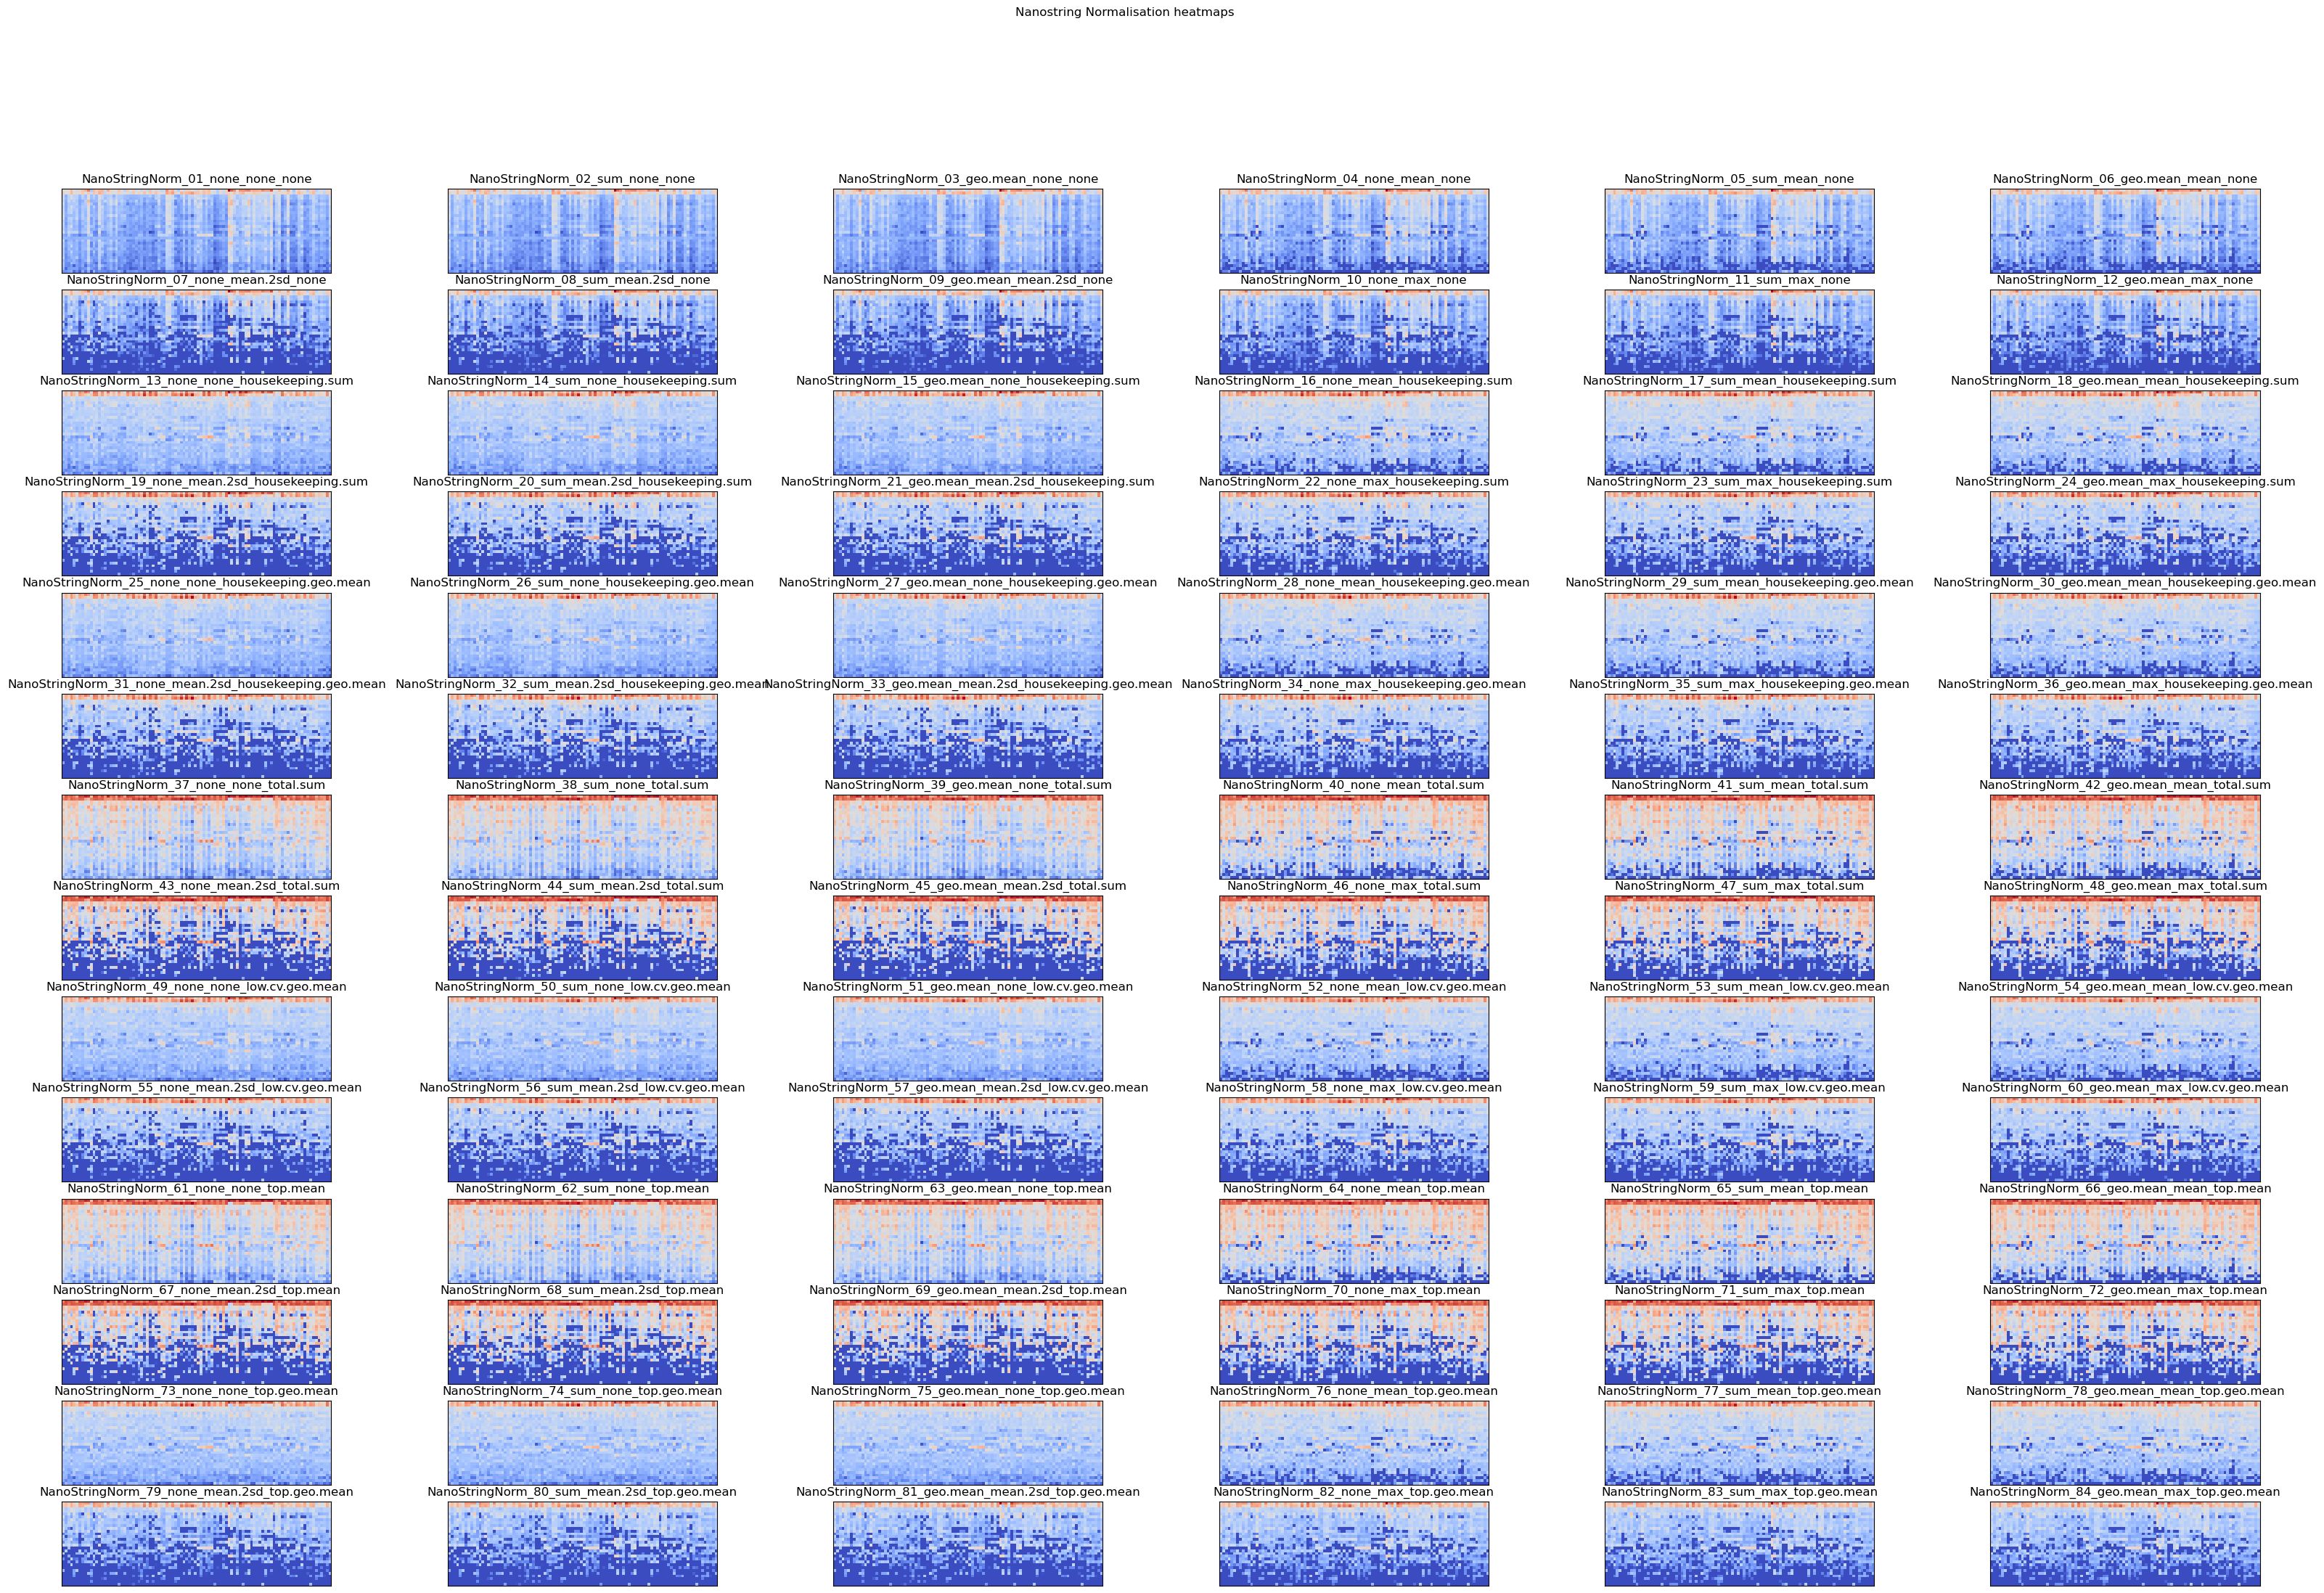

In [40]:
width = 6
height = 14

fig, axs = plt.subplots(height, width, figsize=[40,25])
fig.suptitle('Nanostring Normalisation heatmaps')
for y in range(height):
    for x in range(width):
        fileIdx = x + y*width
        tempDF = pd.read_csv(os.path.join(normDir, 'NSNormDropped',files[fileIdx]), index_col=0)
        axs[y][x].matshow(np.log2(tempDF + 1), cmap='coolwarm')
        axs[y][x].set_xticks([])
        axs[y][x].set_yticks([])
        axs[y][x].set_title(files[fileIdx][:-4])
    
# plt.tight_layout()
# fig.show()
fig.savefig('NSNormDropped.png')

In [41]:
# ToDo: Need function to drop samples from sample info file

# generate groups for EdgeR analysis
## <span style="color:green"> Continue with viewing data and QC of normalised data </sapan>

<div class="alert alert-block alert-danger">
In addition, some text boxes contain particularly important information. These will be coloured red.
</div>

In [42]:
# temp = noneMeanHKDF > 0 

In [43]:
# noneMeanHKDF = pd.read_csv(os.path.join(normDir, 'NSNorm',files[27]), index_col=0)
noneMeanHKDF = pd.read_csv(os.path.join(normDir, 'NSNormDropped',files[27]), index_col=0)


In [44]:
# noneMeanHKDF

In [45]:
# groupedExpressedIndex = noneMeanHKDF.loc[probeOrder].loc[((noneMeanHKDF > 0 ).sum(axis = 1) / len(noneMeanHKDF.columns) > 0.33333)].index


In [46]:
# groupedExpressedIndex

In [47]:
# len(groupedExpressedIndex)

In [48]:
QCData = pd.read_csv(os.path.join(normDir, QCDataFile), index_col=0)

QCData

,Code.Class,X24_008_3_4_5um_QUT_TMA3_001_Tumour,X24_008_3_4_5um_QUT_TMA3_002_TME,X24_008_3_4_5um_QUT_TMA3_002_Tumour,X24_008_3_4_5um_QUT_TMA3_003_TME,X24_008_3_4_5um_QUT_TMA3_003_Tumour,X24_008_3_4_5um_QUT_TMA3_004_Tumour,X24_008_3_4_5um_QUT_TMA3_005_TME,X24_008_3_4_5um_QUT_TMA3_005_Tumour,X24_008_3_4_5um_QUT_TMA3_006_TME,...,X24_008_3_4_5um_QUT_TMA1_025_TME,X24_008_3_4_5um_QUT_TMA1_025_Tumour,X24_008_3_4_5um_QUT_TMA1_028_TME,X24_008_3_4_5um_QUT_TMA1_028_Tumour,X24_008_3_4_5um_QUT_TMA1_029_Tumour,X24_008_3_4_5um_QUT_TMA1_031_Tumour,X24_008_3_4_5um_QUT_TMA1_032_Tumour,X24_008_3_4_5um_QUT_TMA1_034_Tumour,X24_008_3_4_5um_QUT_TMA1_038_TME,X24_008_3_4_5um_QUT_TMA1_038_Tumour
Name,,,,,,,,,,,,,,,,,,,,,
HYB-POS,Positive,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,...,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300
Ms IgG1,Negative,88.318370,15.564713,37.219936,52.260920,26.159107,34.030502,17.576359,33.942234,26.529974,...,11.509533,8.607013,19.780296,57.670895,13.070210,12.312470,19.126610,21.334110,8.508138,53.152554
Rb IgG,Negative,40.962685,11.180616,6.825781,21.395008,7.180270,15.048419,4.205146,12.785937,8.571124,...,5.224617,3.322979,9.102513,22.578619,4.004455,7.150788,6.909553,10.844656,5.607757,22.151590
Ms IgG2a,Negative,15.780657,7.439528,16.752287,6.716254,10.093098,5.619662,3.107048,5.834095,6.090702,...,7.490107,1.760256,6.893129,9.728003,7.256543,6.193330,8.219649,3.960484,2.751489,18.242323
HYB-NEG,Negative,1.991002,1.578515,1.988170,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.776323,1.000000,1.439413,1.000000,1.000000,1.723165,1.000000,5.697998,1.000000,1.150792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IDO1,Endogenous,2.067240,3.277912,1.988170,1.940209,1.000000,1.623422,1.000000,1.000000,1.000000,...,1.776323,1.587766,2.596309,1.551179,2.715535,1.789145,3.075947,2.366472,1.644071,1.150792
B7-H3,Endogenous,1.000000,1.578515,4.107736,2.926486,1.000000,1.000000,1.687476,2.762601,1.905870,...,1.776323,1.000000,2.413318,1.806325,1.779337,1.000000,2.015495,1.139600,1.000000,1.150792
VISTA,Endogenous,2.207986,1.578515,1.988170,2.072307,1.000000,3.638306,1.000000,1.000000,2.898633,...,1.776323,1.000000,1.334848,1.539196,1.910133,1.000000,2.163650,1.139600,1.000000,2.552415


# Run EdgeR analysis

Write comparisons to a text file that will be parsed by the r script

In form of factor.variable, factor.variable2, comparisonName
1 comparison per line

  make_option(c("-d", "--datadir"), type="character", default=NULL, 
              help="dataset file name", metavar="character"),
  make_option(c("-f", "--file"), type="character", default=NULL, 
              help="dataset file name", metavar="character"),
  make_option(c("-e", "--exportdir"), type="character", default="NSNorm", 
              help="dataset file name", metavar="character"),
  make_option(c("-i", "--sampleinfo"), type="character", default=NULL, 
              help="dataset file name", metavar="character")

### extract potential factors for analysis from info file

### extract potential groups based on factors

### Show group numbers for each of the comparisons

### Set up config file for EdgeR 

#### (Use helper notebook or uncomment code below)

In [49]:
# # groups = ['Broad_classification']
# comps = [
#     []
# ]

# compNames = []
# for g in comps:
#     ctemp = []
#     for c in g:
#         c = c.replace('.','_')
#         c = c.replace(' - ','_vs_')
#         ctemp.append(c)
#     compNames.append(ctemp)

# compNames

In [50]:
# outFile = 'EdgeR_Config.txt'

# outLines = []
# for g in range(len(groups)):
#     groupLine = 'GROUP:' + groups[g]
#     outLines.append(groupLine)
    
#     compLine = 'COMPARISON:'
#     compNameLine = 'COMP_NAME:'
#     for c in range(len(comps[g])):
#         compLine += comps[g][c]
#         compLine += ','
#         compNameLine += compNames[g][c]
#         compNameLine += ','
    
#     outLines.append(compLine)
#     outLines.append(compNameLine)

# with open(outFile, 'w') as o:
#     o.write('\n'.join(outLines))
#     o.write('\n')

In [51]:
# configDict['rootDir']

In [52]:
# ToDo: Ensure that EdgeR_config.txt has been populated

In [53]:
# Choose normalisation file for use with edgeR

normPath = os.path.join('Normalisation','NSNormDropped')
# normPath = os.path.join('Normalisation','NSNorm')
print(normPath)

# normFile = 'NanoStringNorm_52_none_mean_low.cv.geo.mean.csv'
# normFile = 'NanoStringNorm_49_none_none_low.cv.geo.mean.csv'
normFile = 'NanoStringNorm_25_none_none_housekeeping.geo.mean.csv'
# normFile = 'NanoStringNorm_13_none_none_housekeeping.sum.csv'
print(normFile)



Normalisation/NSNormDropped
NanoStringNorm_25_none_none_housekeeping.geo.mean.csv


In [54]:
# Define sample info file, export directory and 

sampleinfoFile = 'sampleInfo_with_Wells.csv'

runname = 'NS' + normFile[10:17]
exportdir = os.path.join('EdgeR', runname)
print(f'exportdir : {exportdir}')


# ensure export directory is created

try:
    os.mkdir(os.path.join(configDict['rootDir'], exportdir))
except FileNotFoundError:
    os.mkdir(os.path.join(configDict['rootDir'], exportdir.split('/')[0]))
except FileExistsError:
    pass
try:
    os.mkdir(os.path.join(configDict['rootDir'], exportdir))
except FileExistsError:
    pass

exportdir : EdgeR/NSNorm_25


In [55]:
## Need to handle dropped samples that may still be present in sampleinfoFile. 
## Could be handled with another file, or by removing samples within R.


In [56]:
# set up command and run edgeR

cmd = 'Rscript ../DSP_EDA_Protein/EdgeR.R -c ' + os.getcwd()
cmd += ' -d ' + configDict['rootDir']
cmd += ' -n ' + normPath
cmd += ' -f ' + normFile
cmd += ' -e ' + exportdir
cmd += ' -i ' + sampleinfoFile
print(cmd)
os.system(cmd)

Rscript ../DSP_EDA_Protein/EdgeR.R -c /Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Batra_EOI -d /Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/ -n Normalisation/NSNormDropped -f NanoStringNorm_25_none_none_housekeeping.geo.mean.csv -e EdgeR/NSNorm_25 -i sampleInfo_with_Wells.csv
[1] "Checking libraries:"


Loading required package: edgeR
Loading required package: limma
Loading required package: optparse
Loading required package: stringr


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[1] "If any values above are FALSE, library availability must be checked"
[1] " "
[1] "groups"
[[1]]
[1] NA

[1] "/Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data/"
[1] "/Users/upton6/Documents/Nanostring/projects/Batra_EOI/DSP_Protein_Data//Normalisation/NSNormDropped/NanoStringNorm_25_none_none_housekeeping.geo.mean.csv"
[1] "Normalisation/NSNormDropped"
[[1]]
[1] NA

[1] "groups[g][[1]]"
[1] NA
[1] "NA"


Error in `[.data.frame`(targets, x) : undefined columns selected
Calls: mapply -> <Anonymous> -> [ -> [.data.frame
Execution halted


256

# Convert MD Plots to Volcano Plots

In [57]:
# Get the list of files to run

dataPath = os.path.join(configDict['rootDir'],exportdir,)
filesMaster = []
for root, folder, files in os.walk(dataPath):
    files = [os.path.join(root, f) for f in files if (f.endswith('.csv') and f.startswith('MD_plot'))]
    filesMaster.extend(files)
     

In [58]:
## Run volcano plots

# sigGenes = []
for file in filesMaster:
    if not (file[-7:-4] == '_tr'):
        subGenes = volcanoPlot(dataPath, file, pVal=False)
        # sigGenes.extend(subGenes)
# sigGenes = list(set(sigGenes))
    

# Working

### Plot heatmaps and dendrograms

In [59]:
# ToDo: Ensure heatmaps are using relevant normalised data. Read data from NSNorm or EdgeR files

In [60]:
QCData.drop(labels=['Code.Class'], axis=1)

,X24_008_3_4_5um_QUT_TMA3_001_Tumour,X24_008_3_4_5um_QUT_TMA3_002_TME,X24_008_3_4_5um_QUT_TMA3_002_Tumour,X24_008_3_4_5um_QUT_TMA3_003_TME,X24_008_3_4_5um_QUT_TMA3_003_Tumour,X24_008_3_4_5um_QUT_TMA3_004_Tumour,X24_008_3_4_5um_QUT_TMA3_005_TME,X24_008_3_4_5um_QUT_TMA3_005_Tumour,X24_008_3_4_5um_QUT_TMA3_006_TME,X24_008_3_4_5um_QUT_TMA3_006_Tumour,...,X24_008_3_4_5um_QUT_TMA1_025_TME,X24_008_3_4_5um_QUT_TMA1_025_Tumour,X24_008_3_4_5um_QUT_TMA1_028_TME,X24_008_3_4_5um_QUT_TMA1_028_Tumour,X24_008_3_4_5um_QUT_TMA1_029_Tumour,X24_008_3_4_5um_QUT_TMA1_031_Tumour,X24_008_3_4_5um_QUT_TMA1_032_Tumour,X24_008_3_4_5um_QUT_TMA1_034_Tumour,X24_008_3_4_5um_QUT_TMA1_038_TME,X24_008_3_4_5um_QUT_TMA1_038_Tumour
Name,,,,,,,,,,,,,,,,,,,,,
HYB-POS,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,...,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300,2340.175300
Ms IgG1,88.318370,15.564713,37.219936,52.260920,26.159107,34.030502,17.576359,33.942234,26.529974,144.211350,...,11.509533,8.607013,19.780296,57.670895,13.070210,12.312470,19.126610,21.334110,8.508138,53.152554
Rb IgG,40.962685,11.180616,6.825781,21.395008,7.180270,15.048419,4.205146,12.785937,8.571124,50.736977,...,5.224617,3.322979,9.102513,22.578619,4.004455,7.150788,6.909553,10.844656,5.607757,22.151590
Ms IgG2a,15.780657,7.439528,16.752287,6.716254,10.093098,5.619662,3.107048,5.834095,6.090702,27.731874,...,7.490107,1.760256,6.893129,9.728003,7.256543,6.193330,8.219649,3.960484,2.751489,18.242323
HYB-NEG,1.991002,1.578515,1.988170,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.146362,...,1.776323,1.000000,1.439413,1.000000,1.000000,1.723165,1.000000,5.697998,1.000000,1.150792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IDO1,2.067240,3.277912,1.988170,1.940209,1.000000,1.623422,1.000000,1.000000,1.000000,3.363297,...,1.776323,1.587766,2.596309,1.551179,2.715535,1.789145,3.075947,2.366472,1.644071,1.150792
B7-H3,1.000000,1.578515,4.107736,2.926486,1.000000,1.000000,1.687476,2.762601,1.905870,1.146362,...,1.776323,1.000000,2.413318,1.806325,1.779337,1.000000,2.015495,1.139600,1.000000,1.150792
VISTA,2.207986,1.578515,1.988170,2.072307,1.000000,3.638306,1.000000,1.000000,2.898633,2.364245,...,1.776323,1.000000,1.334848,1.539196,1.910133,1.000000,2.163650,1.139600,1.000000,2.552415


In [61]:
## Subset dataframe to contain only significant probes and relevant AOIs

In [62]:
dendroModel = AgglomerativeClustering(n_clusters=None, 
                                # affinity='euclidean', 
                                # metric='euclidean', 
                                metric='cosine', 
                                memory=None, 
                                connectivity=None, 
                                compute_full_tree=True, 
                                # linkage='ward', 
                                linkage='single', 
                                # linkage='complete', 
                                distance_threshold=0.1, 
                                compute_distances=True
                               )

In [63]:
# ToDo : Add linkage map from cosine

### Read in  Factor lookup tsv file

In [64]:
def read_factor_lookup(file):
    factorLookup = {}
    varLookup = {}
    vars = []
    
    sep = '\t'
    if file.lower().endswith('.tsv'):
        sep= '\t'
    elif file.lower().endswith('.csv'):
        sep= ','
    
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            factorVariable = line.split(':')

            # ToDo: CHeck this is correct patter for assertions
            assert len(factorVariable)==2, 'Factor lookup file is incomplete or incorrectly formatted'
            # print(factorVariable)
            factor = factorVariable[0]
            factor = factor.strip()
            # print(factor)
            variables = factorVariable[1].split(sep)
            # print(variables)
            variables = [x.strip() for x in variables]
            vars.extend(variables)
            for var in variables:
                factorLookup[var] = factor

    return(factorLookup, varLookup, vars)


In [65]:
def get_relevant_AOIs(fileName, factorLookup):
    # Extract subpopulation attributes from file name
    fields = fileName[:-4].split('_')
    fields.remove('MD')
    fields.remove('plot')
    vsIDX = fields.index('vs')
    numIDXs = [x for x in range(vsIDX)]
    denomIDXs = [x for x in range(vsIDX+1,len(fields))]
    AOISuperSets = [[],[]]
    
    for i, IDXs in enumerate([numIDXs,denomIDXs]):
        for idx in IDXs:
            factor = fields[idx]
            print('factor')
            print(factor)
            factorType = factorLookup[factor]
            thisSet = set(sampleInfo.loc[:,sampleInfo.loc[factorType] == factor].columns)
            AOISuperSets[i].append(thisSet)
    numeratorAOIs = set.intersection(*AOISuperSets[0])
    denominatorAOIs = set.intersection(*AOISuperSets[1])     
    relevantAOIs = list(numeratorAOIs | denominatorAOIs)
    relevantAOIs = [x.replace('.',' ') for x in relevantAOIs]
    fields.remove('vs')
    return(relevantAOIs, fields)


In [66]:
factorLookup, varLookup, vars = read_factor_lookup('factor_lookup.tsv')
factors = list(set(factorLookup.values()))
varLookup = dict(zip(vars, np.arange(0.1,0.9,0.8/len(vars))))


for file in filesMaster:   # Iterate through files


    if not (file[-7:-4] == '_tr'):  # Ignore _tr files with more stringent expression thresholding
        print(file)
        fileName = file.split('/')[-1]
        relevantAOIs, fileNameFields = get_relevant_AOIs(fileName, factorLookup)


        ## Move function to get factor lookup et here so that only relevant factors are used for each plot to simplify plots and colouring.



        
        subGenes = volcanoPlot(dataPath, file, pVal=True, plot=False)
        if (len(subGenes) <= 1):
            print('No subgenes were found, continuing with next comparison\n\n')
            continue
        tempDF = pd.read_csv(file)
        tempDF.columns = [x.replace('.',' ') for x in tempDF.columns]
        # heatMapData = QCData.loc[subGenes,relevantAOIs] # Use EdgeR Input data for heatmaps
        heatMapData = tempDF.loc[subGenes,relevantAOIs] # Use EdgeR model output data for heatmaps

        print(heatMapData.shape)
        # print(heatMapData)


        fig, axes = plt.subplots(3, 3, figsize=(len(relevantAOIs)*0.27+3.5, len(subGenes)*0.27+3),width_ratios=[4,len(relevantAOIs),1], height_ratios=[4,2,len(subGenes)])
        ## Generate sample dendrogram

        if ((heatMapData.shape[1])>2):
            # dendroModel = get_AggloModel('EuclideanWard_T', heatMapData)
            # dendroModel = get_AggloModel('CosineWard_T', heatMapData)


            dendroModel = AgglomerativeClustering(n_clusters=None, 
                                    # metric='euclidean', 
                                    metric='cosine', 
                                    memory=None, 
                                    connectivity=kneighbors_graph(heatMapData.T,2), 
                                    # connectivity=sklearn.neighbors.kneighbors_graph(heatMapData.T,2), 
                                    # connectivity=sklearn.neighbors.kneighbors_graph(1 - sklearn.metrics.pairwise.cosine_distances(heatMapData.T),2), 
                                    compute_full_tree=True, 
                                    linkage='complete', 
                                    distance_threshold=0.1, 
                                    compute_distances=True
                                   )

        else:
            dendroModel = get_AggloModel('EuclideanWard_None', heatMapData)

        model = dendroModel.fit(heatMapData.T)
        labels = plot_dendrogram(model, 
                                 truncate_mode=None, 
                                 p=5, 
                                 ax=axes[0][1])
        AOINamesDendro = [heatMapData.columns[int(x)] for x in labels]

        
        ## Generate probe dendrogram
        if ((heatMapData.shape[0])>2):
            dendroModel = get_AggloModel('EuclideanWard', heatMapData)
        else:
            dendroModel = get_AggloModel('EuclideanWard_None', heatMapData)

        model = dendroModel.fit(heatMapData)
        labels = plot_dendrogram(model, 
                                 truncate_mode=None, 
                                 p=5, 
                                 orientation = 'left',
                                 ax=axes[2][0])
        probeNamesDendro = [heatMapData.index[int(x)] for x in labels][::-1]

        axes[0][0].axis('off')
        axes[1][0].axis('off')
        axes[0][2].axis('off')
        axes[1][2].axis('off')
        
        axes[0][1].tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
        axes[1][1].tick_params(left = False, right = True, labelright = True, labelbottom = False, top = False, bottom = False) 
        axes[2][0].tick_params(left = False, right = False, labelleft = False, labelright = False, labelbottom = False, bottom = False) 

        # factors=['Histo_Stage','Segment_Name']
        # varLookup={'IA':0.1,'IIA':0.2,'IIB':0.33,'IV':0.4,'Segment1':0.65,'Segment2':0.85}
        # factors=['Obese','arthritis']
        # varLookup={'NonObese':0.1,'Obese':0.2,'Epi':0.33, 'Sub':0.4, 'Full':0.5, 'NOA':0.65,'OA':0.85}
        # factors=['Broad_classification','Tissue','Cyst_Size']
        # varLookup={'Primary':0.15,'Secondary':0.85, 'purple':0.2, 'green':0.33 , 'mixed':0.4, 'large':0.5, 'small':0.65, 'na':0.95}
        axes[1][1].matshow(get_factor_colours(AOINamesDendro, factors, varLookup, sampleInfo), 
                           cmap = 'gist_rainbow', 
                           aspect='auto', 
                           vmin=0, 
                           vmax=1)
        axes[1][1].yaxis.tick_right()
        axes[1][1].set_yticks(np.linspace(0, len(factors)-1, len(factors)), factors)
        axes[1][1].set_xticks([])

        axes[0][2].matshow([[varLookup[x]] for x in fileNameFields], 
                           cmap = 'gist_rainbow', 
                           aspect='auto', 
                           vmin=0, 
                           vmax=1)
        
        axes[2][1].matshow(np.log2(heatMapData.loc[probeNamesDendro,AOINamesDendro]), cmap = 'coolwarm', aspect='auto')
        axes[2][1].xaxis.tick_bottom()
        axes[2][1].yaxis.tick_right()
        # axes[2][1].set_xticklabels(AOINamesDendro)
        # axes[2][1].set_xticks(np.linspace(0, len(AOINamesDendro)-1, len(AOINamesDendro)), ['AOI_' + x[22:-9] for x in AOINamesDendro], rotation = 45, ha='right')
        axes[2][1].set_xticks(np.linspace(0, len(AOINamesDendro)-1, len(AOINamesDendro)), ['AOI_' + x[22:] for x in AOINamesDendro], rotation = 45, ha='right')
        axes[2][1].set_yticks(np.linspace(0, len(probeNamesDendro)-1, len(probeNamesDendro)), probeNamesDendro)

        norm = Normalize(vmin=np.log2(heatMapData.values.max()), vmax=np.log2(heatMapData.values.max()), clip=False)
        fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), cax=axes[2][2])
        
        fig.suptitle(fileName[:-4])
        plt.tight_layout()
        plt.savefig(file[:-4] + '_Heatmap.svg')
        plt.show()
        # break


In [67]:
factors = list(set(factorLookup.values()))

In [68]:
np.arange(0.1,0.9,0.8/len(factors))

array([0.1, 0.5])

In [69]:
factors

['Row', 'Col']

In [70]:
vars

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H']

In [71]:
varLookup = zip


In [72]:
dict(zip(factors, np.arange(0.1,0.9,0.8/len(factors))))

{'Row': 0.1, 'Col': 0.5}

In [73]:
# ToDo : Add x ticks to sample plot
# ToDo : Add legend for sample ID plot
# ToDo : Add legend for heatmap
# ToDo : automate extraction of factor names and variables

# ToDo : Use a lookup dictionary to abbreviate/shorten probe names. OR, work out a better spacing method to accommodate long probe names without creating so much white space.

In [74]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
sampleInfo.index

In [ ]:
import sklearn as sklearn

In [ ]:
knn = sklearn.neighbors.kneighbors_graph(heatMapData,2)
# knn = sklearn.neighbors.kneighbors_graph(heatMapData.T,2)

In [ ]:
knn.A

In [ ]:
plt.matshow(knn.A)

In [ ]:
heatMapData

In [ ]:


result = 1 - sklearn.metrics.pairwise.cosine_distances(heatMapData)

# result = 1 - spatial.distance.cosine(heatMapData)



In [ ]:
result

In [ ]:
plt.matshow(result)

In [ ]:
knnCosine = sklearn.neighbors.kneighbors_graph(result,2)

In [ ]:
knnCosine.A

In [ ]:
plt.matshow(knnCosine.A)

In [ ]:
break

In [ ]:
def calc_nonZero_mean(tempData, cols):
    tempData = tempData.loc[:,cols]
    seriesList=[]
    for factor in tempData.index:
        theseVals = tempData.loc[factor,:]
        byDict = sampleInfoTemp.loc['TMA_Core',cols].to_dict()    
        nonZeroDict = {}
        for k,v in byDict.items():
            thisVal = theseVals[k]
            if thisVal == 0:
                pass
            else:
                try:
                    nonZeroDict[v].append(thisVal)
                except KeyError:
                    nonZeroDict[v] = [thisVal]
        for k,v in byDict.items():
            if v in nonZeroDict.keys():
                nonZeroDict[v] = np.mean(nonZeroDict[v])
            else:
                nonZeroDict[v] = 0
        seriesList.append(pd.Series(nonZeroDict, name=theseVals.name))
    return(pd.DataFrame(seriesList))

In [ ]:
def expression_plot(thisData):
    figure = plt.figure(figsize=(20,10))
    figure.subplots_adjust(bottom=0.35)
    
    suffix = ['NOb_NOA', 'NOb_OA', 'Ob_NOA', 'Ob_OA']
    suffix = ['Normal_BMI', 'Normal_BMI_OA', 'Obese_BMI', 'Obese_BMI_OA']
    suffix = ['Obese_BMI', 'Obese_BMI_OA']
#     print(pd.DataFrame(thisData))
    # print('thisData')
    # print(thisData)
    
    # for p, cols in enumerate([NOb_NOA_Cols, NOb_OA_Cols, Ob_NOA_Cols, Ob_OA_Cols]):
    for p, cols in enumerate([Ob_NOA_Cols, Ob_OA_Cols]):
        tempData = calc_nonZero_mean(thisData, cols)
        pos = []
        for n in range(len(thisData.index)):
            # pos.append((n*4)+p+1)
            pos.append((n*3)+p+1)
        plt.boxplot(tempData.T, sym='-', labels=tempData.index+'_'+suffix[p], positions=pos)
#         plt.boxplot(tempData.T, sym='-', labels='FOXP3'+'_'+suffix[p], positions=pos)

        for i,j in enumerate(tempData.index):
            

            y = tempData.loc[j]
            colours = [colourList[0] if v in AOIDict['NOb_NOA'] else colourList[1] if v in AOIDict['NOb_OA'] else colourList[2] if v in AOIDict['Ob_NOA'] else colourList[3] for v in y.index]
            y = y.values
            # x = np.random.normal(1+p+(i*4), 0.1, len(y))
            x = np.random.normal(1+p+(i*3), 0.1, len(y))
            for i in range(len(x)): 
                plt.plot(x[i], y[i], c=colours[i], marker='.')
        plt.xticks(rotation = 90)
        # plt.xlabel=list(endogNorm.index[startIdx:endIdx])
    #     plt.xlabel=['CD80', 'CD66b', 'PD-L2', 'GITR', 'Phospho-GSK3B (S9)']

    plt.title('Normalised Probe Values (Log2 transformed)', size=36)
    plt.ylabel('Log2 probe value', size=24)
    plt.tight_layout(h_pad=2)
    plt.savefig(file[:-4] + '_Folicles.svg')
    plt.show()
    plt.close()
    

In [ ]:
os.getcwd()

In [ ]:
TB = ['CD20','PD-1', 'CD3', 'CD4', 'CD8', 'CTLA4', 'CD45RO', 'FOXP3', '4-1BB', 'LAG3', 'Tim-3', 'GITR', 'CD127', 'CD25', 'CD27']

# KeepNames = ['IP_TMA_OA_2022_07_28_036_Full.ROI',
#  # 'IP_TMA_OA_2022_07_28_073_Full.ROI',
#  # 'IP_TMA_OA_2022_07_28_074_Full.ROI',
#  'IP_TMA_OA_2022_07_28_042_Full.ROI',
#  'IP_TMA_OA_2022_07_28_051_Full.ROI',
#  'IP_TMA_OA_2022_07_28_053_Full.ROI',
#  'IP_TMA_OA_2022_07_28_086_Full.ROI',
#  'IP_TMA_OA_2022_07_28_092_Full.ROI']


KeepNames = ['IP_TMA_OA_2022_07_28_073_Full ROI',
 'IP_TMA_OA_2022_07_28_074_Full ROI',
 'IP_TMA_OA_2022_07_28_042_Full ROI',
 'IP_TMA_OA_2022_07_28_051_Full ROI',
 'IP_TMA_OA_2022_07_28_053_Full ROI',
 'IP_TMA_OA_2022_07_28_086_Full ROI',
 'IP_TMA_OA_2022_07_28_092_Full ROI']



In [ ]:
# sampleInfo

In [ ]:
tempDF = pd.read_csv(file)
tempDF.columns = [x.replace('.',' ') for x in tempDF.columns]
sampleInfoTemp = sampleInfo.copy()
sampleInfoTemp.columns = [x.replace('.',' ') for x in sampleInfoTemp.columns]

In [ ]:
# sampleInfoTemp

In [ ]:
tempInfo = sampleInfoTemp.loc[:,KeepNames]

In [ ]:
# tempInfo

In [ ]:
NOb = tempInfo.loc[:,sampleInfoTemp.loc['Obese'] == 'NonObese']
Ob = tempInfo.loc[:,sampleInfoTemp.loc['Obese'] == 'Obese']

NOb_NOA_Cols = NOb.loc[:,NOb.loc['arthritis'] == 'NOA'].columns
NOb_OA_Cols = NOb.loc[:,NOb.loc['arthritis'] == 'OA'].columns

Ob_NOA_Cols = Ob.loc[:,Ob.loc['arthritis'] == 'NOA'].columns
Ob_OA_Cols = Ob.loc[:,Ob.loc['arthritis'] == 'OA'].columns

In [ ]:
AOIDict = {}
suffix = ['NOb_NOA', 'NOb_OA', 'Ob_NOA', 'Ob_OA']
for i, cols in enumerate([NOb_NOA_Cols, NOb_OA_Cols, Ob_NOA_Cols, Ob_OA_Cols]):
    AOIDict[suffix[i]] = list(sampleInfoTemp.loc['TMA_Core',cols].values)

In [ ]:
colourList = [[   1, 0.5019607843137255, 0.0],
              [0.3333333333333333, 0.6274509803921569,0.984313725490196],
              [0.7215686274509804,0.33725490196078434,0.8431372549019608],
              [0,1, 0]]


In [ ]:
tempDF = tempDF.loc[:,tempDF.columns[7:]]

In [ ]:
# tempDF.loc[TB, KeepNames]

In [ ]:
# sampleInfoTemp.loc[['Obese','arthritis'],KeepNames]

In [ ]:
# tempDF

In [ ]:
# tempDF.loc[TB, KeepNames]

In [ ]:
expression_plot(np.log2(tempDF.loc[TB, KeepNames]))

In [ ]:
tempDF

In [ ]:
break

In [ ]:
# dataPath = '../../../Nanostring/projects/.../DSP_Protein_Data/'
dataPath = configDict['rootDir']
data = pd.read_csv(os.path.join(dataPath,'HK_Geo_Mean_Normalised.csv'), index_col = 0)
probeFilter = pd.read_csv(os.path.join(dataPath,'Probe_Filter.csv'), index_col = 0)
sampleInfo = pd.read_csv(os.path.join(dataPath,'Sample_Info.csv'), index_col = 0)

# dataPath = '../../../Nanostring/projects/.../EdgeR/EdgeR_normData.tsv'
dataPath = os.path.join(configDict['rootDir'], normPath, normFile)

data = pd.read_csv(dataPath, index_col = 0)

# dataPath = '../../../Nanostring/projects/.../DSP_Protein_Data/'
dataPath = configDict['rootDir']


In [ ]:
data

In [ ]:
sampleInfo.columns

In [ ]:
wb = load_workbook(os.path.join(dataPath,'Annotation template file-1a_wells_02.xlsx'))

print(wb.sheetnames)



In [ ]:
ws = wb['Annotation template']

segments = [[y.value for y in x] for x in ws[ws.calculate_dimension()]]
df = pd.DataFrame(segments)


rowLabels = df.iloc[1:,0]
colLabels = df.iloc[0,1:]
annotations = df.iloc[1:,1:]
rowLabels += '_'
rowLabels += df.iloc[1:,1]
rowLabels += '_Full ROI'



In [ ]:
rowLabels

In [ ]:
colLabels

In [ ]:
annotations.values

In [ ]:
sampleAnnotations = pd.DataFrame(annotations.values, index=rowLabels, columns=colLabels)

# sampleAnnotations = sampleAnnotations.T
# sampleAnnotations.set_index(0, drop=True, inplace=True)
# sampleAnnotations = sampleAnnotations.T
# sampleAnnotations.set_index('Scan name', drop=True, inplace=True)
# sampleAnnotations = sampleAnnotations.T



In [ ]:
sampleAnnotations

In [ ]:
sampleAnnotations = sampleAnnotations.join(sampleInfo.T,lsuffix='Drop').T

In [ ]:
sampleAnnotations.drop(labels=[x for x in sampleAnnotations.index if x.endswith('Drop')], inplace=True)

In [ ]:
sampleInfo = sampleAnnotations

In [ ]:
sampleInfo

In [ ]:
def standardize_data(arr):
         
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    
    for column in range(columns):
        
        mean = np.mean(X[:,column])
        std = np.std(X[:,column])
        tempArray = np.empty(0)
        
        for element in X[:,column]:
            
            tempArray = np.append(tempArray, ((element - mean) / std))
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

In [ ]:
# Standardizing data

### I'm not sure that the transpose is what i want here. The data is the wrong shape and pc's seems to be being calculated for proteins instead of samples
X = endogNorm.transpose().values
# X = endogNorm.values
### Try to get pc's for samples
# X = endogNorm.values

## ??? With transpose makes PCA for effect of variables on smaples, without makes PCA for effects of variables on protein expression levels
###^^^ Maybe the other way round?



X_cols = endogNorm.columns
print(X_cols.shape)
y = endogNorm.index
print(y.shape)
X = standardize_data(X)
print(X.shape)


In [ ]:
# Calculating the covariance matrix

covariance_matrix = np.cov(X.T)
# covariance_matrix = np.cov(X)



print(covariance_matrix.shape)


In [ ]:
# Using np.linalg.eig function

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print("Eigenvector: \n",eigen_vectors,"\n")
print("Eigenvalues: \n", eigen_values, "\n")
print(eigen_vectors.shape)

In [ ]:
eigenDF = pd.DataFrame(eigen_vectors, index=[endogNorm.index], columns=[endogNorm.index])
# eigenDF = pd.DataFrame(eigen_vectors, index=[endogNorm.columns], columns=[endogNorm.columns])

In [ ]:
# Calculating the explained variance on each of components


variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)
        
print(variance_explained)

In [ ]:
# Identifying components that explain at least 95%

cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)


In [ ]:
cumulative_variance_explained = [np.float64(x) for x in cumulative_variance_explained]

In [ ]:
cumulative_variance_explained[0].dtype

In [ ]:
# Visualizing the eigenvalues and finding the "elbow" in the graphic


sns.lineplot(x = [i for i in range(len(cumulative_variance_explained))], y=cumulative_variance_explained)
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative explained variance")
# plt.title("Explained variance vs Number of components")



# ToDo:
# Add lines for 95% variance, and number of components describing at least 95% of variance



In [ ]:
# Using two first components (because those explain more than 95%)

projection_matrix = (eigen_vectors.T[:][:50]).T
print(projection_matrix)

In [ ]:
colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' for x in X_cols]
colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' if x.split('_')[-1] == 'Immune' else 'purple' for x in X_cols]


In [ ]:
# I dont think this gives relevant info. projection matrix needs to be combined with original data to see effects of components on patients

plt.scatter([x[0] for x in projection_matrix], [x[1] for x in projection_matrix])#, c=colours)

projection_matrix.shape

In [ ]:
plt.scatter([x[2] for x in projection_matrix], [x[1] for x in projection_matrix])#, c=colours)


In [ ]:
plt.scatter([x[2] for x in projection_matrix], [x[3] for x in projection_matrix])#, c=colours)


In [ ]:
# Getting the product of original standardized X and the eigenvectors 


X_pca = X.dot(projection_matrix)
print(X_pca)

In [ ]:
X_pca.shape

In [ ]:
sampleInfo

In [ ]:
# tagDF = pd.DataFrame( data=[x.split(',') for x in sampleInfo.loc['Segment tags']], index=sampleInfo.columns, columns=['Obese','Arth','Patellar'])

In [ ]:
# tagDF

In [ ]:
# sampleInfo = pd.concat([sampleInfo,tagDF.T])

In [ ]:
sampleInfo

In [ ]:
inforSortedIndex = sampleInfo.sort_values(by=['Obese','arthritis','TMA_Core'], axis=1).columns

In [ ]:
### Add umap / tSNE analysis here